# Example: Tree ensembles 

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [25]:
using EvoTrees
using Statistics
using JuMP
using Gurobi
using Gogeta
using Plots
using LaTeXStrings


## Generate dataset

In this example, we are going to generate random sample points where $x_1, x_2 \in [-0.5, 0.5]$ and the function is defined as follows:
$$f(x_1, x_2) = x_1^2 + x_2^2$$

We will generate two datasets: training (750 samples) and testing (250 samples).

In [12]:
data = rand(1000, 2) .- 0.5;
x_train = data[1:750, :];
y_train = vec(sum(map.(x->x^2, x_train), dims=2));

x_test = data[751:end, :];
y_test = vec(sum(map.(x->x^2, x_test), dims=2));

To understand the dataset better, we need to plot it:

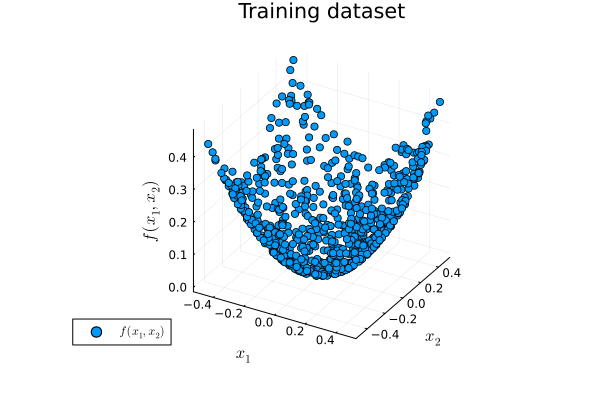

In [28]:
Plots.plot(x_train[:, 1], x_train[:, 2], y_train, label=L"f(x_1,x_2)", xlabel=L"x_1", ylabel=L"x_2", zlabel = L"f(x_1, x_2)", title="Training dataset", seriestype=:scatter)

## Train tree ensemble

Innitialize tree ensembles with any setting you want and train it on training dataset. In our case, `nrounds=500` and `max_depth=5`. 

More details about input parameters can be found in [Julia documentation](https://docs.juliahub.com/EvoTrees/InsE8/0.12.5/models/)

In [31]:

config = EvoTreeRegressor(nrounds=500, max_depth=5);
evo_model = fit_evotree(config; x_train, y_train, verbosity=0);
evo_model

EvoTree{EvoTrees.MSE, 1}
 - Contains 501 trees in field `trees` (incl. 1 bias tree).
 - Data input has 2 features.
 - [:target_levels, :target_isordered, :fnames, :feattypes, :edges, :featbins] info accessible in field `info`


Now, since we have trained ensemble of trees, we can make predictions on training and testing datasets. We can measure the performance of ensemple, based on $r_2$ score. 

$$r_2 = 1-\frac{\sum_{i=1}^N (y_i - h_i)^2}{\sum_{i=1}^N(y_i - E(y))^2}$$

Where $y$ is true value of function, $h$ is our prediction and $E(y)$ can be approximated as a sample mean of the dataset.

In [33]:
pred_train = EvoTrees.predict(evo_model, x_train);
pred_test = EvoTrees.predict(evo_model, x_test);
r2_score_train = 1 - sum((y_train .- pred_train).^2) / sum((y_train .- mean(y_train)).^2)
r2_score_test = 1 - sum((y_test .- pred_test).^2) / sum((y_test .- mean(y_test)).^2)

println("R2 score on the training set is ", r2_score_train)
println("R2 score on the testing set is ", r2_score_test)

R2 score on the training set is 0.999548952559468
R2 score on the testing set is 0.9964934966957512


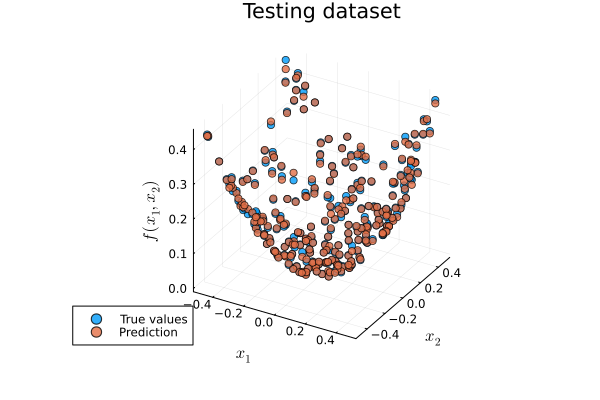

In [40]:
Plots.plot(x_test[:, 1], x_test[:, 2], y_test, label="True values", xlabel=L"x_1", ylabel=L"x_2", zlabel = L"f(x_1, x_2)", title="Testing dataset", seriestype=:scatter, alpha=0.8)
Plots.plot!(x_test[:, 1], x_test[:, 2], pred_test, label="Prediction",  seriestype=:scatter, alpha=0.8)

## Extract information from tree and formulate MIP problem

Now, using trained ensemble model, we can extract the [] using function `extract_evotrees_info()` from Gogeta library. The function input arguments are: the trained `EvoTreeRegressor` model and `tree_limit` (number of trees to exatract, by default we extract all trees). It outputs a custom datatype `TEModel` that stores next information:
- `n_trees`: number of trees in the ensemble
- `n_feats`: number of features (input variables) in the model
- `n_leaves`: number of leaves on each tree
- `leaves`: indices of the leaves on each tree
- `splits`: [feature, splitpoint index] pairs accessible by [tree, node]
- `splits_ordered`: splitpoints ordered by split value for each feature
- `n_splits`: number of splitpoints for each feature
- `predictions`: prediction of each node (zero for nodes that are not leaves)
- `split_nodes`: boolean array containing information whether a node is a split node or not


In [42]:
# Extract data from EvoTrees model
universal_tree_model = extract_evotrees_info(evo_model);
universal_tree_model

TEModel(501, 2, [1, 16, 16, 16, 16, 16, 16, 16, 16, 16  …  13, 13, 15, 16, 13, 12, 16, 14, 16, 15], Array[[1], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]  …  [8, 9, 11, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31], [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], [13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], [7, 

For the next parts, make sure that the `Gurobi` is properly installed (installation instructions can be found here or you can follow `Gurobi` videoguides). We innitialize the jump model and set up the attributes as we wish to.

In [54]:
jump = Model(() -> Gurobi.Optimizer());
set_attribute(jump, "OutputFlag", 0) # JuMP or solver-specific attributes can be changed
jump

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

Innitialy model is empty.

Now we can formulate tree ensemble as a jump model using `TE_formulate!`. This function has next input parameters:
- `opt_model`: A JuMP model where the formulation will be saved to.
- `TE`: A tree ensemble model in the universal data type TEModel.
- `objective`: MINSENSE or MAXSENSE. Minimize or maximize the tree ensemble output.

***Note:*** make sure that for the second parameter you pass output of `extract_evotrees_info()` and not the ensemble itself. 

Our goal is to minimize $$f(x_1, x_2) = x_1^2+x_2^2$$

The minimum occurs at $[x_1, x_2]$ = $[0, 0]$ with objective function $f(0,0) = 0$

In [ ]:
TE_formulate!(jump, universal_tree_model, MIN_SENSE);
# HERE I WANT TO OUTPUT THE MODEL WITH CONSTRAINTS BUT THERE IS AN ERROR
jump

### Solve problem with all split contraints

Now, lets try to optimize the model with all split constraints:

In [64]:
# Solve first by creating all split constraints
add_split_constraints!(jump, universal_tree_model)
optimize!(jump)

# Show results
println("The model found next solution:\n", get_solution(jump, universal_tree_model))
println("With objective function: ",objective_value(jump))

The model found next solution:
Vector[[-0.009135704112662315, 0.011531094866675138], [-0.011578346660118574, 0.0019942583867811024]]
With objective function: -0.000881250415961099


### Solve problem with 'lazy constraints'

This time we need to define our `Gurobi.Optimizer` as direct model and then we can formulate our jump problem as before.

In [77]:
jump = direct_model(Gurobi.Optimizer());
set_silent(jump)
TE_formulate!(jump, universal_tree_model, MAX_SENSE);
jump

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


A JuMP Model
Maximization problem with:
Variables: 7287
Objective function type: AffExpr
`VariableRef`-in-`MathOptInterface.ZeroOne`: 126 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 7161 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 124 constraints
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 501 constraints
Model mode: DIRECT
Solver name: Gurobi
Names registered in the model: x, y

For lazy constraints approach we need to define a callback function, which is different for each solver. See JuMP documentation or your solver's Julia interface documentation. Make sure that your callback function calls `tree_callback_algorithm()`.

Arguments
- `cb_data`: Callback data
- `TE`: A tree ensemble model in the universal data type TEModel.
- `opt_model`: A JuMP model containing the formulation.



In [78]:
function split_constraint_callback_gurobi(cb_data, cb_where::Cint)

    # Only run at integer solutions
    if cb_where != GRB_CB_MIPSOL
        return
    end

    Gurobi.load_callback_variable_primal(cb_data, cb_where)
    tree_callback_algorithm(cb_data, universal_tree_model, jump)

end

split_constraint_callback_gurobi (generic function with 1 method)

In [79]:
set_attribute(jump, "LazyConstraints", 1)
set_attribute(jump, Gurobi.CallbackFunction(), split_constraint_callback_gurobi)

optimize!(jump)

# Show results
println("The model found next solution:\n", get_solution(jump, universal_tree_model))
println("With objective function: ",objective_value(jump))

The model found next solution:
Vector[[0.48614588724691665, Inf], [0.46703725534207197, 0.47910900537210266]]
With objective function: 0.46970103075400294


## Recommendations

Using the tree ensemble optimization from this package is quite straightforward. The only parameter the user can change is the solution method: with initial constraints or with lazy constraints. In our computational tests, we have seen that the lazy constraint generation almost invariably produces models that are computationally easier to solve. Therefore we recommend primarily using it as the solution method, but depending on your use case, trying the initial constraints might also be worthwhile.